# LUAD CPTAC analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from msresist.figures.figure3 import plotR2YQ2Y, plotPCA
from msresist.figures.figure1 import pca_dfs, plotClustergram
from msresist.figures.figureM1 import plotErrorAcrossMissingnessLevels, plotWinsAcrossMissingnessLevels, plotMissingnessDensity, plotErrorAcrossNumberOfClusters, plotErrorAcrossWeights
from msresist.logistic_regression import plotClusterCoefficients, plotPredictionProbabilities, plotConfusionMatrix
from msresist.pre_processing import preprocessing, filter_NaNpeptides, MeanCenter, Log2T
from msresist.clustering import MassSpecClustering
from msresist.motifs import MapMotifs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Data

In [4]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [5]:
X.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsGGGVS,NP_002577.2,PBX2,S146-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071547,-0.600298,0.172339,-1.761406,0.421872,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.25423,-0.378522,0.987749,-0.189486
2,AAAAAsTQAQQ,NP_001035540.1,MINDY2,S575-p,0.012034,-0.630863,-1.159479,-0.740044,0.107228,-0.016971,-0.023379,-0.481045,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83783,-0.993838,0.317079,...,0.031572,-0.554645,-0.033640,-1.268642,0.266790,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Distribution of Missingness

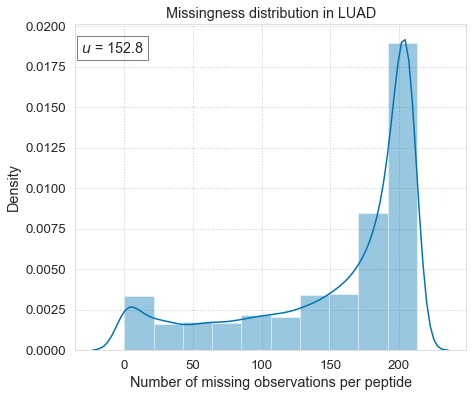

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotMissingnessDensity(ax, d)

## Handling Missingness

### Reconstruction Error across different percentages of missingness

Introduce artificial missing data by leaving values out, and then seeing how well that values are represented by the corresponding clusters.

PAM250:

Missingness %:  0
Weight:  0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 3
Re-initialize GMM clusters, empty cluster(s) at iteration 4
Re-initialize GMM, NaN responsibilities at iteration 4
Re-initialize GMM clusters, empty cluster(s) at iteration 6
Re-initialize GMM clusters, empty cluster(s) at iteration 7
Re-initialize GMM clusters, empty cluster(s) at iteration 8
Re-initialize GMM clusters, empty cluster(s) at iteration 9
Re-initialize GMM, NaN responsibilities at iteration 9
Re-initialize GMM clusters, empty cluster(s) at iteration 11
Re-initialize GMM clusters, empty cluster(s) at iteration 12
Re-initialize GMM, NaN responsibilities at iteration 12
Re-initialize GMM, NaN responsibilities at iteration 13
Re-initialize GMM clusters, empty cluster(s) at iteration 15
Re-initialize GMM clusters, empty cluster(s) at iteration 16
Re-initialize GMM clusters, empty cluster(s) at iteration 17
Re-initialize GMM cluste

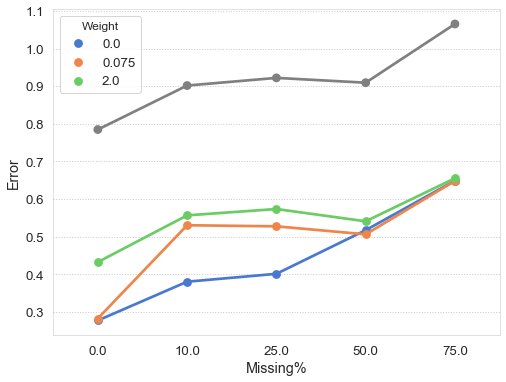

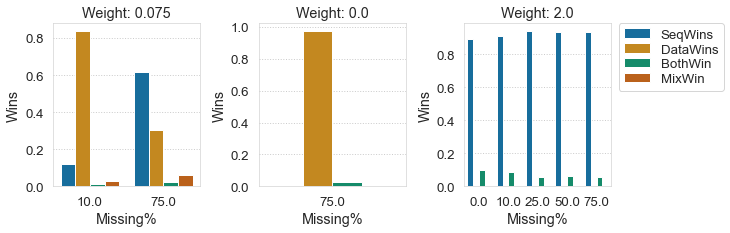

In [7]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
m_ = plotErrorAcrossMissingnessLevels(ax, X, [0, 0.075, 2], "PAM250", 15, 50, baseline=True)

fig, ax = plt.subplots(1, 3, figsize=(10,3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
plotWinsAcrossMissingnessLevels(ax, m_)

Binomial:

In [2]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
m_ = plotErrorAcrossMissingnessLevels(ax, X, [0, 2, 10], "Binomial", 20, 50, baseline=True)

fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
fig.subplots_adjust(wspace=0.4, hspace=0.4)
plotWinsAcrossMissingnessLevels(ax, m_)

### Reconstruction Error across different number of clusters

Re-initialize GMM, NaN responsibilities at iteration 2
Re-initialize GMM, NaN responsibilities at iteration 1
Re-initialize GMM, NaN responsibilities at iteration 3
Re-initialize GMM, NaN responsibilities at iteration 5
Re-initialize GMM, NaN responsibilities at iteration 7
Re-initialize GMM, NaN responsibilities at iteration 1
Re-initialize GMM, NaN responsibilities at iteration 3
CPU times: user 58min 16s, sys: 8min 30s, total: 1h 6min 46s
Wall time: 3h 14min 24s


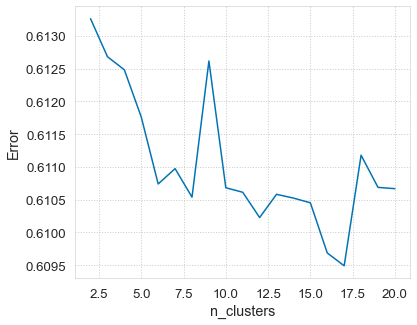

In [17]:
%%time
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotErrorAcrossNumberOfClusters(ax, X, 0.075, "PAM250", np.arange(2, 21), 200)

In [58]:
# %%time
# fig, ax = plt.subplots(1,1,figsize=(6,5))
# plotErrorAcrossWeights(ax, X, 0.1, [0, 0.1, 0.25, 0.5, 0.75, 1, 2], "PAM250", 10, 200)

## 6. Run Model
Filter peptides based on a threshold of missingness

In [7]:
X_f = filter_NaNpeptides(X, cut=0.1)
X_f.index = np.arange(X_f.shape[0])
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

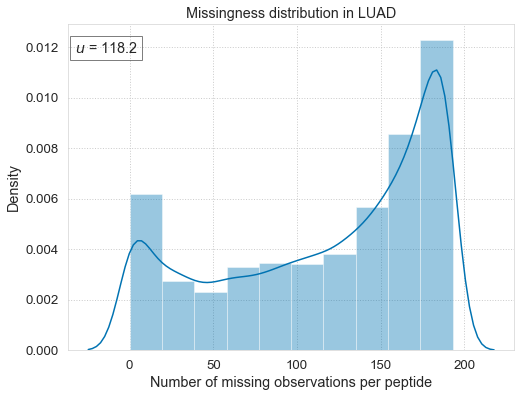

In [63]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plotMissingnessDensity(ax, d_f)

Run model:

In [18]:
%%time
MSC = MassSpecClustering(i_f, ncl=15, SeqWeight=2, distance_method="Binomial", n_runs=3).fit(d_f, "NA")

CPU times: user 2min 41s, sys: 5.4 s, total: 2min 46s
Wall time: 2min 40s


In [19]:
MSC.wins_

(11226, 8623, 3214, 2203)

Save model:

In [20]:
with open('CPTACmodel_Binomial_W2_15CL', 'wb') as f:
    pickle.dump([MSC], f)

Load if necessary:

In [21]:
# with open('CPTACmodel_PAM250_W020_15CL', 'rb') as f:
#     MSC = pickle.load(f)[0]

### Hierarchical Clustering

In [22]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]
centers.iloc[:, :-1] = zscore(centers.iloc[:, :-1], axis=1)

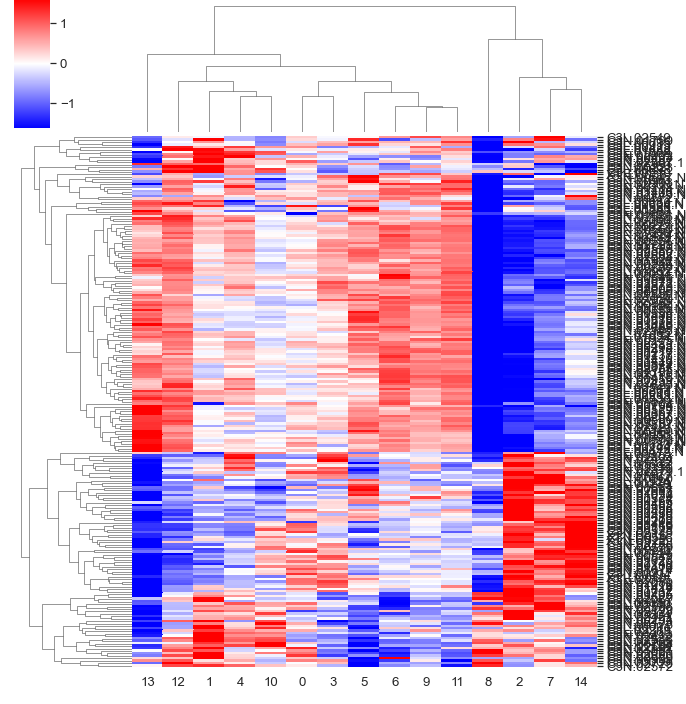

In [23]:
centers = centers.set_index(["Patient_ID"])
plotClustergram(centers, "", lim=max(np.max(np.abs(centers)) * 0.5), figsize=(10, 10), yticklabels=True)
centers = centers.reset_index()
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

### PCA Analysis

In [26]:
from msresist.figures.figureM1 import TumorType

centers = TumorType(centers)
c = 2

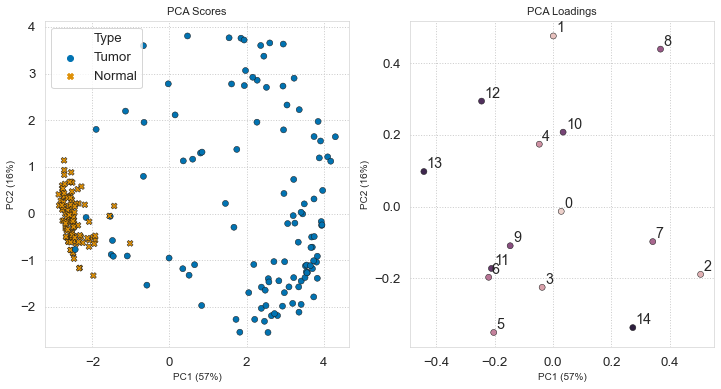

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plotPCA(ax, centers, c, ["Patient_ID", "Type"], "Cluster", hue_scores="Type", style_scores="Type", hue_load="Cluster")

## 7. Regression against Clinical Features

In [29]:
from msresist.figures.figureM1 import Trn
from scipy.stats import zscore
centers, y = TransformCPTACdataForRegression(MSC, d_f, list(X.columns[4:]))
centers.iloc[:, 1:] = zscore(centers.iloc[:, 1:])

### PLSR

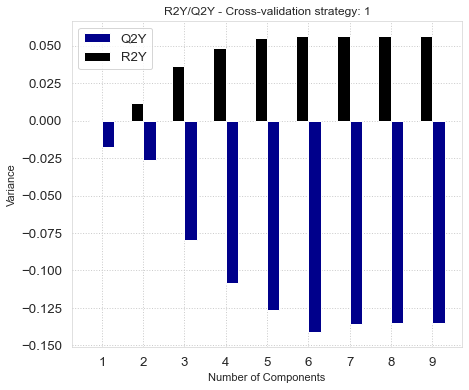

In [30]:
p10 = PLSRegression(n_components=2, scale=True)
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, p10, centers.iloc[:, 1:], y.iloc[:, 1], 1, 10)
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

### Logistic Regression

In [185]:
dd = centers.iloc[:, 1:]
yy = y.iloc[:, 1]

lr = LogisticRegressionCV(cv=ncl, class_weight={1:8}, solver="saga", penalty="l1", Cs=5).fit(dd, yy)
y_pred = lr.predict(dd)
print(y_pred)

lr_score = lr.score(dd, yy)
print(lr_score)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
0.9195979899497487


#### Coefficients

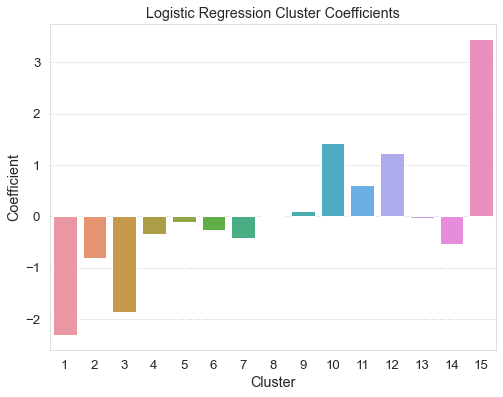

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr)

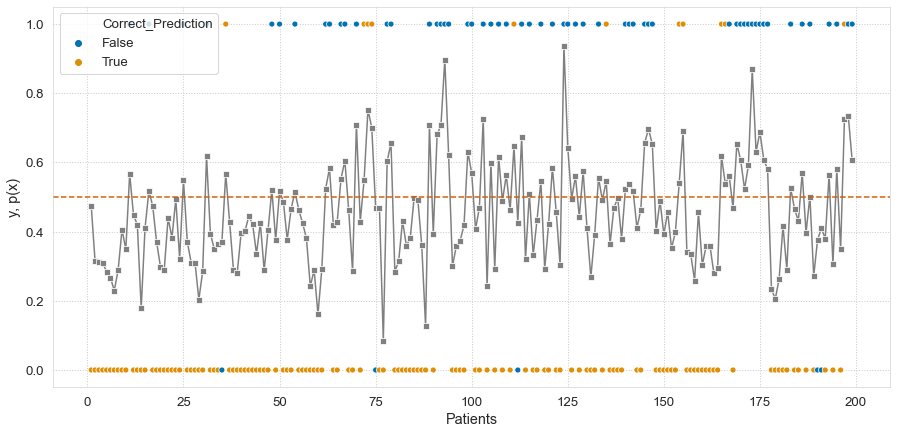

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plotPredictionProbabilities(ax, lr, y_pred, dd, yy)

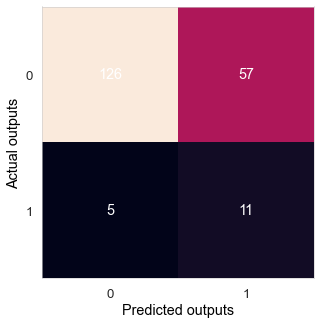

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr, dd, yy)

### Support Vector Machine

In [173]:
from sklearn.svm import LinearSVC

clf = LinearSVC(penalty="l1", dual=False, class_weight={1:4}, C=2, random_state=100).fit(dd, yy)

clf_pred = clf.predict(dd)
print(clf_pred)

clf_score = clf.score(dd, yy)
print(clf_score)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0.]
0.914572864321608


Text(0.5, 1.0, 'SVC Cluster Coefficients')

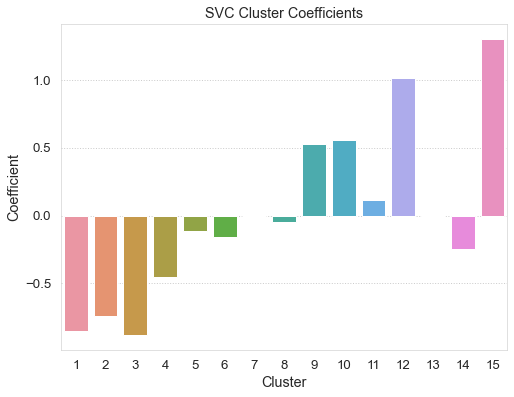

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, clf)
ax.set_title("SVC Cluster Coefficients")

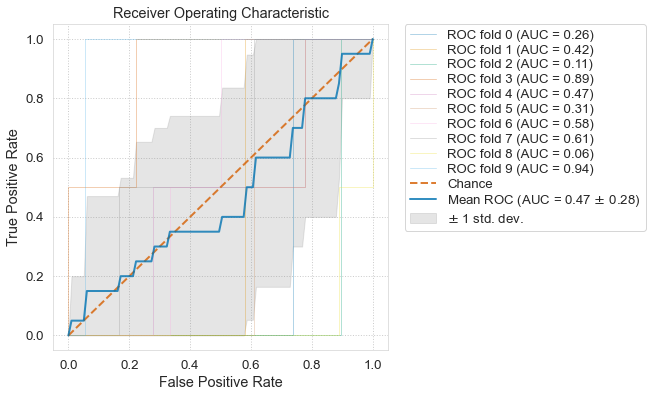

In [189]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LinearSVC(penalty="l1", dual=False, class_weight={1:4})
# classifier = LogisticRegressionCV(cv=10, class_weight={1:8}, solver="saga", penalty="l1", Cs=5).fit(dd, yy)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

dd_ = dd.values
yy_ = yy.values

fig, ax = plt.subplots(figsize=(6, 6))
for i, (train, test) in enumerate(cv.split(dd_, yy_)):
    classifier.fit(dd_[train], yy_[train])
    viz = plot_roc_curve(classifier, dd_[test], yy_[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2)
plt.show()

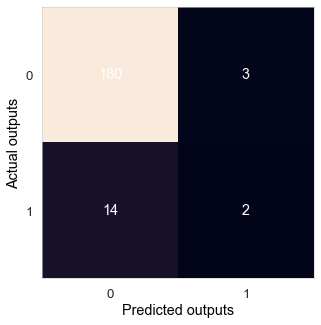

In [176]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, clf, dd, yy)